In [120]:
import importlib
import data_loading   # your file, e.g. court_listener_cleaner.py

importlib.reload(data_loading)

<module 'data_loading' from '/Users/ilyadavidson/Stanford_Internship/judge_project/data_loading.py'>

In [126]:
import importlib, api_call
importlib.reload(api_call)
import pandas as pd
from data_loading import build_cap_dataset, court_listener_cleaner
from main import judges_promoted_from_district
from helper_functions import norm_id
from helper_functions import plot_distributions
from api_call import _extract_text
from api_call import load_case_results
import json
import seaborn as sns

In [ ]:
promoted        = pd.read_csv('results/promoted_judge_stats.csv')
judges          = pd.read_csv('data/judge_info.csv')
with open("results/appellate_matches.json", "r", encoding="utf-8") as f:
    app_matches = json.load(f)   
df = build_cap_dataset()
court_listener = pd.read_csv('third_circuit_on_appeal.csv')

Working dir: /Users/ilyadavidson/Stanford_Internship/judge_project
Found 28 parquet files for pattern: data/parquet_files/CAP_data_*.parquet


In [336]:
cl = pd.read_csv('third_circuit_on_appeal.csv')
cl = cl[cl['docket_number'].notna()] # remove nas
cl = cl.drop_duplicates(subset="docket_number", keep="first") # drop dupes

In [340]:
cl_dockets = cl["docket_number"].dropna().astype(str).unique().tolist()
cap_dockets = df["docket_number"].dropna().astype(str).unique().tolist()

def has_overlap(cl_docket: str, cap_dockets=cap_dockets) -> bool:
    for cap_d in cap_dockets:
        if cl_docket in cap_d or cap_d in cl_docket:
            return True
    return False

cl["overlap_by_substring"] = cl["docket_number"].astype(str).apply(has_overlap)

total = len(cl)
overlap = cl["overlap_by_substring"].sum()
non_overlap = total - overlap

print(f"Total CourtListener cases: {total}")
print(f"Overlap by substring with CAP: {overlap}")
print(f"No overlap with CAP: {non_overlap}")

Total CourtListener cases: 2705
Overlap by substring with CAP: 1915
No overlap with CAP: 790


In [344]:
overlap = cl[cl['overlap_by_substring']==True]

In [345]:
court_listener = court_listener_cleaner(overlap, judges, "combined_preview", df, "docket_number", "unique_id")
court_listener = court_listener[court_listener['judge id'].notna()]
court_listener = court_listener[court_listener['unique_id'].notna()]
court_listener = court_listener.drop_duplicates(subset="unique_id", keep="first")

In [346]:
len(court_listener)

683

In [347]:
court_listener

,cluster_id,case_name,docket_number,combined_preview,overlap_by_substring,district_judge,district_judge_clean,court_name,judge id,unique_id
135,10125252,Raymond Lofstad v. Secretary United States Dep...,24-1420,PRECEDENTIAL\n\n UNITED STATES COURT OF...,True,Robert Kirsch,kirsch,for the District of New Jersey.,13619516,79294
196,9769002,United States v. Tahjair Dorsey,23-2125,PRECEDENTIAL\n\n UNITED STATES COURT O...,True,Matthew W. Brann,brann,for the Middle District of Pennsylvania.,3455,82917
498,6238418,SodexoMAGIC LLC v. Drexel University,19-1028,PRECEDENTIAL\n\n UNITED STATES COURT OF AP...,True,Michael M. Baylson,baylson,for the Eastern District of Pennsylvania.,2941,9151
520,5297762,United States v. David Shulick,18-3305,PRECEDENTIAL\n\n UNITED STATES COURT OF...,True,"Harvey Bartle, III",bartle,for the Eastern District of Pennsylvania.,111,47602
555,4957838,United States v. Corey Grant,16-3820,PRECEDENTIAL\n\n UNITED STATES COURT OF ...,True,Jose L. Linares,linares,for the District of New Jersey.,2978,74886
...,...,...,...,...,...,...,...,...,...,...
2342,769630,Planned Parenthood of Central New Jersey Herbe...,99-5042,220 F.3d 127 (3rd Cir. 2000) PLANNED PARENTHOO...,True,Anne E. Thompson[Copyrighted Material Omitted]...,court,,13761867,37984
2349,769159,"Lucien B. Calhoun Robin L. Calhoun, Individual...",99-1378,216 F.3d 338 (3rd Cir. 2000) LUCIEN B. CALHOUN...,True,Louis H. Pollak[Copyrighted Material Omitted] ...,law,,1351,70199
2374,767848,"In Re: Magic Restaurants, Inc. Magic American ...",99-5113,205 F.3d 108 (3rd Cir. 2000) IN RE: MAGIC REST...,True,"Joseph J. Farnan, Jr. Stephen P. McCarron, Esq...",paca,,1822,5078
2417,766243,"United States of America, Ex Rel. Erdem I. Can...",98-3552,192 F.3d 402 (3rd Cir. 1999) UNITED STATES OF ...,True,"Donald E. Ziegler, Chief JudgeRobert L. Potter...",court,,13761867,69968


In [3]:
len(df[df['is_appellate']==1])

51339

In [297]:
df[df['is_appellate']==1].sample(1)

,name,docket_number,decision_date,court_name,jurisdiction,cite,cites_to,judges_raw,judges_clean,judges_ids,opinion_type,opinion_author_raw,opinion_author_clean,opinion_author_id,opinion_text,unique_id,is_appellate,docket_norm,overlap
60769,"UNITED STATES of America, Plaintiff-Appellant,...",No. 75-2282,1976-07-16,United States Court of Appeals for the Third C...,U.S.,539 Federal Reporter 2d Series 301,"390 United States Reports 987, 385 United Stat...","Before ALDISERT, FORMAN and WEIS, Circuit Judges.","[aldisert, forman, weis]","[21, 781, 2540]",majority,"FORMAN, Circuit Judge.",forman,781.0,"OPINION OF THE COURT\nFORMAN, Circuit Judge.\n...",60769,1,NO752282,False


In [300]:
appellate_ids = df[df['is_appellate'] == 1]['unique_id'].astype(str)
matched = appellate_ids.isin(app_matches.keys()).sum()
print(f"We were able to match {matched} out of {len(appellate_ids)} appellate cases ({matched/len(appellate_ids):.2%})")

We were able to match 5818 out of 51339 appellate cases (11.33%)


In [303]:
len(court_listener)

699

In [171]:
print(f"There are {len(judges['judge id'].unique())} total judges.") # total number of judges in dataset

aj = judges[judges['court type'].str.contains('Appeals|Circuit', case=False, na=False)]

print(f"There are {len(aj['judge id'].unique())} appellate judges") # unique appellate judges

dj = judges[judges['court type'].str.contains('District')]

print(f"There are {len(dj['judge id'].unique())} district judges") # unique district judges

There are 4026 total judges.
There are 882 appellate judges
There are 3277 district judges


In [172]:
def promotion_info_judges(judge_info):
    """
    Returns a df of all judges who got promoted from district to appellate courts. Their promotion date is the earliest nomination date that they got to the appellate court. 
    """
    ji = judge_info.copy()
    ji['promotion date'] = pd.NaT

    aj = ji[ji['court type'].str.contains('Appeals|Circuit', case=False, na=False)]
    dj = ji[ji['court type'].str.contains('District')]
    pj = dj[dj['judge id'].isin(aj['judge id'])].copy()
    pj['nomination date'] = pd.to_datetime(pj['nomination date'], errors='coerce')
    pj = pj.sort_values(['judge id','nomination date']).drop_duplicates('judge id', keep='first')

    ji['is promoted'] = ji['judge id'].isin(pj['judge id']).astype(int)
    ji['promotion date'] = ji.apply(lambda row: pj[pj['judge id']==row['judge id']]['nomination date'].values[0] if row['is promoted'] else pd.NaT, axis=1)
    ji_district = ji[ji['court type'].str.contains('District')]
    ji_district = ji_district.drop_duplicates('judge id', keep='first')
    return ji_district

In [173]:
dsct_jdges = promotion_info_judges(judges) # district judges with promotion info
len(dsct_jdges)

3277

In [174]:
dsct_jdges.sample(1)

,judge id,last name,first name,gender,ethnicity,birth year,birth city,birth state,death year,death city,...,ayes/nays,confirmation date,commission date,school 1,degree 1,school 2,degree 2,professional career,promotion date,is promoted
410,264,bristol,William,Male,White,1779,Hamden,CT,1836.0,New Haven,...,,1826-05-22,1826-05-22,Yale College,NaN,Read law,NaN,"Private practice, New Haven, Connecticut, 1800...",NaT,0


In [17]:
len(dsct_jdges[dsct_jdges['is promoted']==1]) / len(dsct_jdges) * 100 # proportion of district judges who got promoted

9.826060421116875

In [18]:
len(dsct_jdges[(dsct_jdges['court name'].str.contains(r"Delaware|New Jersey|Pennsylvania|Virgin Islands")) & (dsct_jdges['is promoted']==1)]) / len(dsct_jdges[dsct_jdges['court name'].str.contains(r"Delaware|New Jersey|Pennsylvania|Virgin Islands")]) * 100 # proportion of district judges in the third court who got promoted

11.411411411411411

In [19]:
len(dsct_jdges[(dsct_jdges['court name'].str.contains(r"Delaware|New Jersey|Pennsylvania|Virgin Islands")) & (dsct_jdges['is promoted']==1)])

38

In [20]:
thrd_judges = dsct_jdges[dsct_jdges['court name'].str.contains(r"Third|Delaware|New Jersey|Pennsylvania|Virgin Islands")]

In [203]:
import json
import pandas as pd

def compute_district_overturns(
    df:             pd.DataFrame,
    dsct_judges:    pd.DataFrame,
    api_path:       str = "batch_runs/api_responses.jsonl",
    mapping_path:   str = "results/appellate_matches.json",
    court_listener: pd.DataFrame = None,
) -> pd.DataFrame:

    pj                     = dsct_judges.copy()
    dsc                    = df[df['is_appellate'] == 0].copy()
    dsc["_author_id_norm"] = dsc["opinion_author_id"].map(norm_id)

    by_judge_cases = (
        dsc
        .dropna(subset=["_author_id_norm"])
        .groupby("_author_id_norm")
        .apply(lambda g: list(g.index))
        .to_dict()
    )

    pj["_judge_id_norm"]      = pj["judge id"].map(norm_id)
    pj["district_cases_list"] = pj["_judge_id_norm"].map(by_judge_cases).apply(lambda x: x if isinstance(x, list) else [])
    pj["district cases"]      = pj["district_cases_list"].str.len().astype(int)

    # ----- Load mapping + API opinions -----
    try:
        with open(mapping_path, "r", encoding="utf-8") as f:
            app_to_dct = json.load(f)
    except FileNotFoundError:
        app_to_dct = {}

    opinions = {}
    overturned_district_indices = set()

    try:
        with open(api_path, "r", encoding="utf-8") as f:
            for line in f:
                if not line.strip():
                    continue
                rec = json.loads(line)
                if rec.get("error"):
                    continue
                txt = _extract_text(rec.get("response", {}))
                if not txt:
                    continue
                try:
                    obj = json.loads(txt)
                except json.JSONDecodeError:
                    continue

                opinion = (obj.get("opinion") or "").strip().lower()
                cid     = str(rec.get("custom_id"))
                if cid:
                    opinions[cid] = opinion

                if opinion and opinion != "affirmed":
                    if cid in app_to_dct:
                        try:
                            overturned_district_indices.add(int(app_to_dct[cid]))
                        except Exception:
                            pass
    except FileNotFoundError:
        pass

    # Appeals coverage count (mapping-based)
    appealed_district_cases = set(app_to_dct.values())
    pj["appealed cases"] = pj["district_cases_list"].apply(
        lambda case_list: sum(1 for cid in case_list if cid in appealed_district_cases)
    ).astype(int)

    # ===== CourtListener: add tallies to district & appealed (no extra column) =====
    if court_listener is not None and not court_listener.empty:
        cl = court_listener.copy()
        cl["judge id"] = pd.to_numeric(cl["judge id"], errors="coerce").astype("Int64")
        cl = cl.dropna(subset=["judge id", "docket_number"])
        cl["docket_number"] = cl["docket_number"].astype(str)

        # distinct CL dockets per judge
        cl_counts = (
            cl.groupby("judge id")["docket_number"]
              .nunique()
              .astype(int)
        )

        # add directly to totals (fill missing with 0)
        add_series = pj["judge id"].map(cl_counts).fillna(0).astype(int)
        pj["district cases"] = (pj["district cases"] + add_series).astype(int)
        pj["appealed cases"] = (pj["appealed cases"] + add_series).astype(int)

    # ----- Overturned (mapping) -----
    def _count_overturned(case_list):
        if not case_list:
            return 0
        return sum(1 for cid in case_list if cid in overturned_district_indices)

    pj["overturned_from_mapping"] = pj["district_cases_list"].apply(_count_overturned).astype(int)

    # ----- CourtListener overlap augmentation (overturned) -----
    extra_overturned_by_judge = {}

    if court_listener is not None and not court_listener.empty:
        cl2 = court_listener.dropna(subset=["docket_number"]).copy()
        cl2["judge id"] = pd.to_numeric(cl2["judge id"], errors="coerce").astype("Int64")
        cl2 = cl2.dropna(subset=["judge id"])
        cl_dockets = cl2["docket_number"].astype(str).dropna().unique().tolist()

        def has_overlap(docket: str) -> bool:
            if not isinstance(docket, str):
                return False
            return any(docket in cl_d or cl_d in docket for cl_d in cl_dockets)

        df_local = df.copy()
        df_local["__has_docket"] = df_local["docket_number"].notna()
        df_local["overlap"] = False
        mask = df_local["__has_docket"]
        df_local.loc[mask, "overlap"] = df_local.loc[mask, "docket_number"].astype(str).apply(has_overlap)

        overlap_cases = df_local[df_local["overlap"] & df_local["unique_id"].notna()].copy()
        overlap_cases["unique_id"] = overlap_cases["unique_id"].astype(str)

        cl_rows = cl2[["docket_number", "judge id"]].copy()
        cl_rows["docket_number"] = cl_rows["docket_number"].astype(str)

        for df_docket, block in overlap_cases.groupby("docket_number"):
            df_docket = str(df_docket)
            cl_judges = set(
                int(j) for d, j in zip(cl_rows["docket_number"], cl_rows["judge id"])
                if (df_docket in d) or (d in df_docket)
            )
            if not cl_judges:
                continue

            uids_here = set(block["unique_id"].astype(str).unique())
            non_aff = [u for u in uids_here if (opinions.get(u, "").lower() not in ("", "affirmed"))]
            if not non_aff:
                continue

            for jid in cl_judges:
                extra_overturned_by_judge[jid] = extra_overturned_by_judge.get(jid, 0) + 1

    def _cl_extra_for_row(row) -> int:
        jid = row.get("judge id")
        if pd.isna(jid):
            return 0
        return int(extra_overturned_by_judge.get(int(jid), 0))

    pj["overturned_from_cl"] = pj.apply(_cl_extra_for_row, axis=1).astype(int)

    # ----- Combine + rate -----
    pj["district_cases_overturned"] = pj["overturned_from_mapping"] + pj["overturned_from_cl"]
    pj["district_overturn_rate"] = pj.apply(
        lambda r: (r["district_cases_overturned"] / r["district cases"]) if r["district cases"] else pd.NA,
        axis=1
    )
    pj["overturn_rate_among_appeals"] = pj.apply(
    lambda r: (r["district_cases_overturned"] / r["appealed cases"]) if r["appealed cases"] else pd.NA,
    axis=1
)

    pj.drop(columns=["_judge_id_norm"], inplace=True)

    # dtypes
    pj["judge id"]                  = pd.to_numeric(pj["judge id"], errors="coerce").astype("Int64")
    pj["district cases"]            = pd.to_numeric(pj["district cases"], errors="coerce").astype(int)
    pj["appealed cases"]            = pd.to_numeric(pj["appealed cases"], errors="coerce").astype(int)
    pj["overturned_from_mapping"]   = pd.to_numeric(pj["overturned_from_mapping"], errors="coerce").astype(int)
    pj["overturned_from_cl"]        = pd.to_numeric(pj["overturned_from_cl"], errors="coerce").astype(int)
    pj["district_cases_overturned"] = pd.to_numeric(pj["district_cases_overturned"], errors="coerce").astype(int)

    return pj

In [204]:
overturns = compute_district_overturns(df, thrd_judges, court_listener=court_listener)

/var/folders/tk/kx3xr9b97r34q5h9zb1mq2x80000gn/T/ipykernel_67124/1094268343.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: list(g.index))


In [348]:
overturns2 = compute_district_overturns(df, thrd_judges, court_listener=court_listener)

/var/folders/tk/kx3xr9b97r34q5h9zb1mq2x80000gn/T/ipykernel_67124/1094268343.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: list(g.index))


In [205]:
overturns

,judge id,last name,first name,gender,ethnicity,birth year,birth city,birth state,death year,death city,...,promotion date,is promoted,district_cases_list,district cases,appealed cases,overturned_from_mapping,overturned_from_cl,district_cases_overturned,district_overturn_rate,overturn_rate_among_appeals
4,2,acheson,Marcus,Male,White,1828,Washington,PA,1906.0,Pittsburgh,...,1880-01-06,1,"[78820, 78821, 78824, 78825, 78847, 78849, 788...",41,6,0,0,0,0.0,0.0
6,4,ackerman,Harold,Male,White,1928,Newark,NJ,2009.0,West Orange,...,NaT,0,"[3391, 3818, 3846, 25472, 25483, 25560, 25763,...",183,10,2,0,2,0.010929,0.2
62,37,ambrose,Donetta,Female,White,1945,New Kensington,PA,NaN,,...,NaT,0,"[4148, 4344, 4538, 5491, 5531, 6365, 34441, 34...",106,27,5,11,16,0.150943,0.592593
80,3402,andrews,Richard,Male,White,1955,Manchester,England,NaN,,...,NaT,0,"[8045, 8063, 8477, 8489, 8721, 8730, 8754, 880...",177,11,2,2,4,0.022599,0.363636
89,57,archbald,Robert,Male,White,1848,Carbondale,PA,1926.0,Martha`s Vineyard,...,1901-12-05,1,"[79660, 79684, 79733, 79734, 79747, 79748, 797...",78,3,2,0,2,0.025641,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3978,2657,wright,Caleb,Male,White,1908,Georgetown,DE,2001.0,,...,NaT,0,"[1367, 1377, 2847, 15120, 15132, 15133, 15152,...",352,24,13,0,13,0.036932,0.541667
3999,2671,yohn,William,Male,White,1935,Pottstown,PA,NaN,,...,NaT,0,"[3746, 3863, 4014, 4305, 4939, 5244, 7928, 327...",127,14,4,2,6,0.047244,0.428571
4006,2676,young,James,Male,White,1848,Pittsburgh,PA,1914.0,,...,NaT,0,"[81273, 81380, 81478, 81540, 81541, 81590, 816...",24,7,2,0,2,0.083333,0.285714
4012,6839686,younge,John,Male,African American,1955,Philadelphia,PA,NaN,NaN,...,NaT,0,[],0,0,0,0,0,<NA>,<NA>


In [74]:
import json

# Build the opinions dictionary from api_responses.jsonl
opinions = {}
with open("batch_runs/api_responses.jsonl", "r", encoding="utf-8") as f:
    for line in f:
        if not line.strip():
            continue
        rec = json.loads(line)
        if rec.get("error"):
            continue
        txt = _extract_text(rec.get("response", {}))
        if not txt:
            continue
        try:
            obj = json.loads(txt)  # your 9-key model output
        except json.JSONDecodeError:
            continue
        op = (obj.get("opinion") or "").strip().lower()
        cid = str(rec.get("custom_id"))
        if cid:
            opinions[cid] = op

In [78]:
testtest= pd.read_csv("results/promoted_judge_stats.csv")

In [89]:
test = testtest[testtest['district cases']>0]

In [102]:
test['district_cases_overturned'].sum()

np.int64(299)

In [255]:
overturns

,judge id,last name,first name,gender,ethnicity,birth year,birth city,birth state,death year,death city,...,promotion date,is promoted,district_cases_list,district cases,appealed cases,overturned_from_mapping,overturned_from_cl,district_cases_overturned,district_overturn_rate,overturn_rate_among_appeals
4,2,acheson,Marcus,Male,White,1828,Washington,PA,1906.0,Pittsburgh,...,1880-01-06,1,"[78820, 78821, 78824, 78825, 78847, 78849, 788...",41,6,0,0,0,0.0,0.0
6,4,ackerman,Harold,Male,White,1928,Newark,NJ,2009.0,West Orange,...,NaT,0,"[3391, 3818, 3846, 25472, 25483, 25560, 25763,...",183,10,2,0,2,0.010929,0.2
62,37,ambrose,Donetta,Female,White,1945,New Kensington,PA,NaN,,...,NaT,0,"[4148, 4344, 4538, 5491, 5531, 6365, 34441, 34...",106,27,5,11,16,0.150943,0.592593
80,3402,andrews,Richard,Male,White,1955,Manchester,England,NaN,,...,NaT,0,"[8045, 8063, 8477, 8489, 8721, 8730, 8754, 880...",177,11,2,2,4,0.022599,0.363636
89,57,archbald,Robert,Male,White,1848,Carbondale,PA,1926.0,Martha`s Vineyard,...,1901-12-05,1,"[79660, 79684, 79733, 79734, 79747, 79748, 797...",78,3,2,0,2,0.025641,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3978,2657,wright,Caleb,Male,White,1908,Georgetown,DE,2001.0,,...,NaT,0,"[1367, 1377, 2847, 15120, 15132, 15133, 15152,...",352,24,13,0,13,0.036932,0.541667
3999,2671,yohn,William,Male,White,1935,Pottstown,PA,NaN,,...,NaT,0,"[3746, 3863, 4014, 4305, 4939, 5244, 7928, 327...",127,14,4,2,6,0.047244,0.428571
4006,2676,young,James,Male,White,1848,Pittsburgh,PA,1914.0,,...,NaT,0,"[81273, 81380, 81478, 81540, 81541, 81590, 816...",24,7,2,0,2,0.083333,0.285714
4012,6839686,younge,John,Male,African American,1955,Philadelphia,PA,NaN,NaN,...,NaT,0,[],0,0,0,0,0,<NA>,<NA>


In [349]:
bt10 = overturns2[overturns2['district cases']>=30]

In [258]:
bt10

,judge id,last name,first name,gender,ethnicity,birth year,birth city,birth state,death year,death city,...,promotion date,is promoted,district_cases_list,district cases,appealed cases,overturned_from_mapping,overturned_from_cl,district_cases_overturned,district_overturn_rate,overturn_rate_among_appeals
4,2,acheson,Marcus,Male,White,1828,Washington,PA,1906.0,Pittsburgh,...,1880-01-06,1,"[78820, 78821, 78824, 78825, 78847, 78849, 788...",41,6,0,0,0,0.0,0.0
6,4,ackerman,Harold,Male,White,1928,Newark,NJ,2009.0,West Orange,...,NaT,0,"[3391, 3818, 3846, 25472, 25483, 25560, 25763,...",183,10,2,0,2,0.010929,0.2
62,37,ambrose,Donetta,Female,White,1945,New Kensington,PA,NaN,,...,NaT,0,"[4148, 4344, 4538, 5491, 5531, 6365, 34441, 34...",106,27,5,11,16,0.150943,0.592593
80,3402,andrews,Richard,Male,White,1955,Manchester,England,NaN,,...,NaT,0,"[8045, 8063, 8477, 8489, 8721, 8730, 8754, 880...",177,11,2,2,4,0.022599,0.363636
89,57,archbald,Robert,Male,White,1848,Carbondale,PA,1926.0,Martha`s Vineyard,...,1901-12-05,1,"[79660, 79684, 79733, 79734, 79747, 79748, 797...",78,3,2,0,2,0.025641,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3954,2638,wood,Harold,Male,White,1906,Mount Vernon,NY,1972.0,Philadelphia,...,NaT,0,"[16298, 16312, 16321, 16364, 16377, 16382, 163...",321,49,23,0,23,0.071651,0.469388
3977,2656,wortendyke,Reynier,Male,White,1895,Jersey City,NJ,1975.0,,...,NaT,0,"[15067, 15078, 15110, 15122, 15134, 15157, 151...",273,51,21,0,21,0.076923,0.411765
3978,2657,wright,Caleb,Male,White,1908,Georgetown,DE,2001.0,,...,NaT,0,"[1367, 1377, 2847, 15120, 15132, 15133, 15152,...",352,24,13,0,13,0.036932,0.541667
3999,2671,yohn,William,Male,White,1935,Pottstown,PA,NaN,,...,NaT,0,"[3746, 3863, 4014, 4305, 4939, 5244, 7928, 327...",127,14,4,2,6,0.047244,0.428571


In [259]:
bt10[bt10['is promoted']==0]['overturn_rate_among_appeals'].mean()

np.float64(0.4517307809036944)

In [209]:
bt10.groupby("is promoted")["district cases"].mean()

is promoted
0    199.036269
1    180.384615
Name: district cases, dtype: float64

In [260]:
bt10.groupby("is promoted")["overturn_rate_among_appeals"].mean()

is promoted
0    0.451731
1    0.355747
Name: overturn_rate_among_appeals, dtype: object

In [261]:
promoted_mean = bt10[bt10["is promoted"] == 1]["overturn_rate_among_appeals"].mean()
not_promoted_mean = bt10[bt10["is promoted"] == 0]["overturn_rate_among_appeals"].mean()
effect = promoted_mean - not_promoted_mean
print("Average effect of being promoted:", effect)

Average effect of being promoted: -0.09598375951144866


In [254]:
df.sample(1)['name'].iloc[0]

'John W. ANTHUIS, Jr., Appellee, v. COLT INDUSTRIES OPERATING CORPORATION, Administrator of the Colt Industries Operating Corporation Severance Plan and the Colt Industries Operating Corporation Severance Plan, Appellants; Donald Dale GROSCOST, Appellee, v. COLT INDUSTRIES, INC., Colt Industries Operating Corporation Severance Plan and Colt Industries Operating Corporation, as Administrator of the Colt Industries Operating Corporation Severance Plan, Appellants'

In [350]:
import statsmodels.api as sm

# Outcome: promotion (binary)
y = bt10["is promoted"].astype(int)

# Predictor: overturn rate (continuous, or binary if you want high/low)
X = bt10["overturn_rate_among_appeals"].astype(float)
X = sm.add_constant(X)  # add intercept

# Logistic regression
logit_model = sm.Logit(y, X).fit()
print("=== Logistic Regression: is promoted ~ overturn_rate_among_appeals ===")
print(logit_model.summary())

# OLS regression (linear probability model)
ols_model = sm.OLS(y, X).fit()
print("\n=== OLS Regression: is promoted ~ overturn_rate_among_appeals ===")
print(ols_model.summary())

Optimization terminated successfully.
         Current function value: 0.349050
         Iterations 7
=== Logistic Regression: is promoted ~ overturn_rate_among_appeals ===
                           Logit Regression Results                           
Dep. Variable:            is promoted   No. Observations:                  219
Model:                          Logit   Df Residuals:                      217
Method:                           MLE   Df Model:                            1
Date:                Fri, 03 Oct 2025   Pseudo R-squ.:                 0.04204
Time:                        18:03:36   Log-Likelihood:                -76.442
converged:                       True   LL-Null:                       -79.797
Covariance Type:            nonrobust   LLR p-value:                  0.009587
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
con

In [263]:
import statsmodels.api as sm

# Predictor and outcome
bt10["high_overturn"] = (bt10["overturn_rate_among_appeals"] >  0.5).astype(int) # the average
X = bt10["is promoted"].astype(float)
X = sm.add_constant(X)  # add intercept
y = bt10["high_overturn"]

# Logistic regression
logit_model = sm.Logit(y, X).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.604038
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:          high_overturn   No. Observations:                  219
Model:                          Logit   Df Residuals:                      217
Method:                           MLE   Df Model:                            1
Date:                Fri, 03 Oct 2025   Pseudo R-squ.:                 0.03600
Time:                        17:23:39   Log-Likelihood:                -132.28
converged:                       True   LL-Null:                       -137.22
Covariance Type:            nonrobust   LLR p-value:                  0.001671
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.6088      0.151     -4.040      0.000      -0.904      -0.313
is promoted    -1.8761    

/var/folders/tk/kx3xr9b97r34q5h9zb1mq2x80000gn/T/ipykernel_67124/1460846486.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bt10["high_overturn"] = (bt10["overturn_rate_among_appeals"] >  0.5).astype(int) # the average


In [155]:
case_results = load_case_results()
case_results.sample(1)

,opinion,case_type,error_category,petitioner_type,respondent_type,politicality_score,profile_level,lower_judge_first,lower_judge_last,custom_id
13371,reversed and remanded,civil,legal error,other,company,2.0,medium,None,None,66057


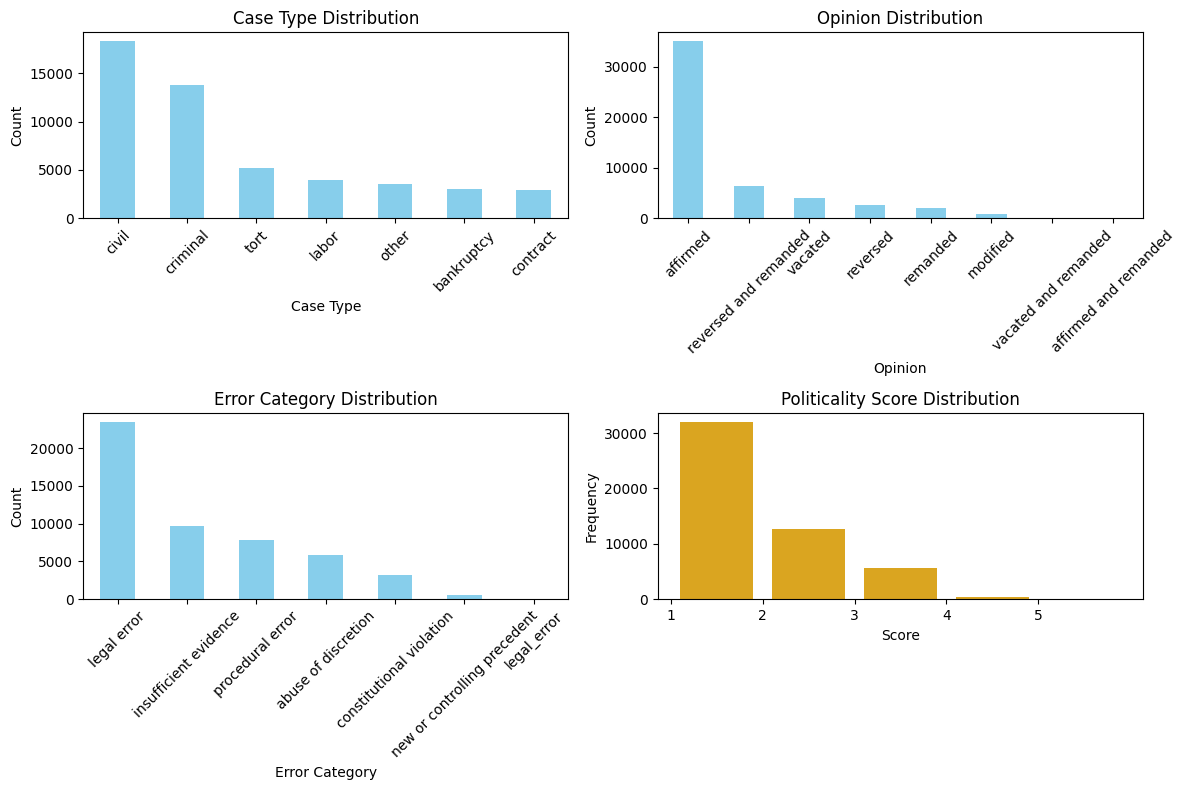

In [156]:
plot_distributions(case_results, ["case_type", "opinion", "error_category", "politicality_score"])

In [558]:
case_results.groupby('case_type').apply(
    lambda group: len(group[group['opinion'] == 'affirmed']) / len(group) * 100
)

/var/folders/tk/kx3xr9b97r34q5h9zb1mq2x80000gn/T/ipykernel_68266/2251497098.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  case_results.groupby('case_type').apply(


case_type
bankruptcy    62.866450
civil         66.695828
contract      59.271978
criminal      75.139726
labor         57.838389
other         82.829978
tort          60.686728
dtype: float64

In [ ]:
len(case_results[case_results['opinion']=='affirmed']) / len(case_results) * 100

68.16137385852528

/var/folders/tk/kx3xr9b97r34q5h9zb1mq2x80000gn/T/ipykernel_79829/1331619923.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bt10["appealed cases"] = bt10["appealed cases"].astype(int)
/var/folders/tk/kx3xr9b97r34q5h9zb1mq2x80000gn/T/ipykernel_79829/1331619923.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bt10["district_overturn_rate"] = bt10["district_overturn_rate"].astype(float)


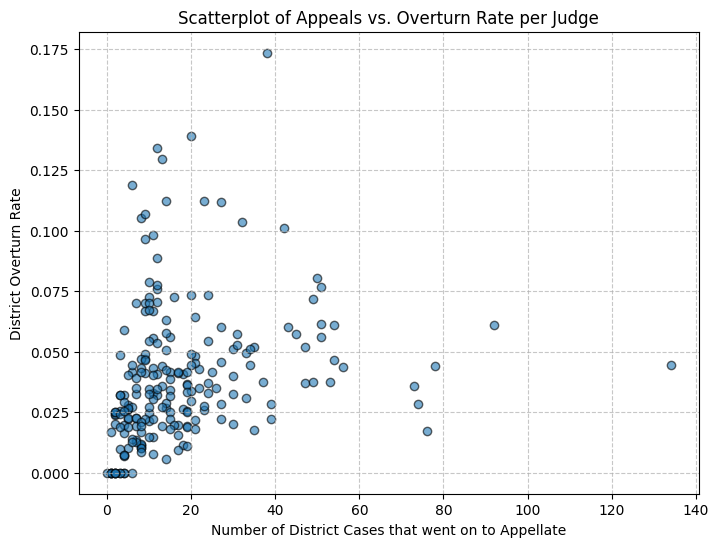

In [74]:
import matplotlib.pyplot as plt

# Example: use your DataFrame "bt10"
# Ensure numeric types
bt10["appealed cases"] = bt10["appealed cases"].astype(int)
bt10["district_overturn_rate"] = bt10["district_overturn_rate"].astype(float)

plt.figure(figsize=(8,6))
plt.scatter(
    bt10["appealed cases"], 
    bt10["district_overturn_rate"], 
    alpha=0.6, edgecolor="k"
)

plt.xlabel("Number of District Cases that went on to Appellate")
plt.ylabel("District Overturn Rate")
plt.title("Scatterplot of Appeals vs. Overturn Rate per Judge")
plt.grid(True, linestyle="--", alpha=0.7)

plt.show()

In [158]:
import json
import numpy as np
import pandas as pd
from scipy.stats import chi2

# Inputs you already have:
# df: cases DataFrame with index = district case id; columns include is_appellate, opinion_author_id
# pj: judges DataFrame with "judge id" and a column "district_cases_list" (list of district case ids per judge)
# mapping_path: JSON mapping {<appellate_id>: <district_index>}

mapping_path = "results/appellate_matches.json"

# 1) Build the set of *district* case ids that were appealed
with open(mapping_path, "r", encoding="utf-8") as f:
    app_to_dct = json.load(f)

appealed_district_ids = set()
for k, v in app_to_dct.items():
    try:
        appealed_district_ids.add(int(v))
    except Exception:
        continue

# 2) Per judge: count how many of their district cases were appealed (regardless of outcome)
def count_appealed(case_list):
    if not isinstance(case_list, (list, tuple)):
        return 0
    return sum(1 for cid in case_list if cid in appealed_district_ids)

pj = bt10.copy()
pj["appealed_cases"] = pj["appealed cases"]

# 3) Quick dispersion view: mean/median/std/CV and a few quantiles
summary = pj["appealed_cases"].describe(percentiles=[0.1,0.25,0.5,0.75,0.9,0.95])
cv = (pj["appealed_cases"].std(ddof=1) / max(summary["mean"], 1e-9))
print("Appealed cases per judge — summary stats")
print(summary)
print(f"Coefficient of Variation (std/mean): {cv:.3f}")

# (Optional) peek at a few extremes
print("\nTop 10 judges by appealed cases:")
print(pj[["judge id","appealed_cases","district cases"]].sort_values("appealed_cases", ascending=False).head(10))

print("\nBottom 10 judges by appealed cases (with at least 1 district case):")
print(pj[pj["district cases"]>0][["judge id","appealed_cases","district cases"]]
      .sort_values("appealed_cases", ascending=True).head(10))

# 4) Are judges getting “about the same” number appealed given exposure?
#    Test: assume a common appeal probability p across judges; compare observed vs expected with Pearson χ².
#    Only include judges with at least 1 district case to avoid division issues.
g = pj[pj["district cases"] > 0].copy()
n = g["district cases"].to_numpy(dtype=float)       # exposures (trials)
obs = g["appealed_cases"].to_numpy(dtype=float)

# Global appeal rate p-hat:
p_hat = obs.sum() / n.sum() if n.sum() > 0 else np.nan
exp = n * p_hat

# Filter out judges whose expected count is ~0 (no power there)
mask = exp > 0
obs2 = obs[mask]
exp2 = exp[mask]
k = obs2.size

if k >= 2 and np.isfinite(p_hat):
    chi2_stat = ((obs2 - exp2)**2 / exp2).sum()
    # degrees of freedom ~ (k - 1) because we estimated a single parameter p_hat
    df_ = max(k - 1, 1)
    p_value = 1 - chi2.cdf(chi2_stat, df_)
    print("\nGoodness-of-fit to a single common appeal rate (binomial with exposure):")
    print(f"- p_hat (overall appeal rate): {p_hat:.4f}")
    print(f"- Pearson χ²: {chi2_stat:.2f} on {df_} df  ->  p = {p_value:.4g}")
    if p_value < 0.05:
        print("⇒ Variation across judges is larger than expected if all shared the same appeal rate.")
    else:
        print("⇒ No strong evidence of heterogeneity; appealed counts look consistent with a common rate.")
else:
    print("\nNot enough data to run the goodness-of-fit test (check exposures).")

# 5) (Optional) Standardized residuals per judge to see who’s high/low relative to exposure
if k >= 2 and np.isfinite(p_hat):
    # Avoid division by zero
    denom = np.sqrt(np.maximum(exp, 1e-12))
    g["std_resid"] = (obs - exp) / denom
    print("\nJudges with largest positive residuals (more appeals than expected given exposure):")
    print(g[["judge id","appealed_cases","district cases","std_resid"]]
          .sort_values("std_resid", ascending=False).head(10))
    print("\nJudges with most negative residuals (fewer appeals than expected):")
    print(g[["judge id","appealed_cases","district cases","std_resid"]]
          .sort_values("std_resid", ascending=True).head(10))

Appealed cases per judge — summary stats
count    217.000000
mean      17.769585
std       17.746737
min        0.000000
10%        3.000000
25%        7.000000
50%       12.000000
75%       21.000000
90%       39.000000
95%       51.000000
max      134.000000
Name: appealed_cases, dtype: float64
Coefficient of Variation (std/mean): 0.999

Top 10 judges by appealed cases:
      judge id  appealed_cases  district cases
1969      1287             134             629
1370       896              92             624
950        616              78             590
3071      2032              76            1112
2267      1484              74             529
2424      1597              73             749
3802      2527              56             709
2678      1763              54             245
1184       773              54             388
3208      2118              53             347

Bottom 10 judges by appealed cases (with at least 1 district case):
      judge id  appealed_cases  distric

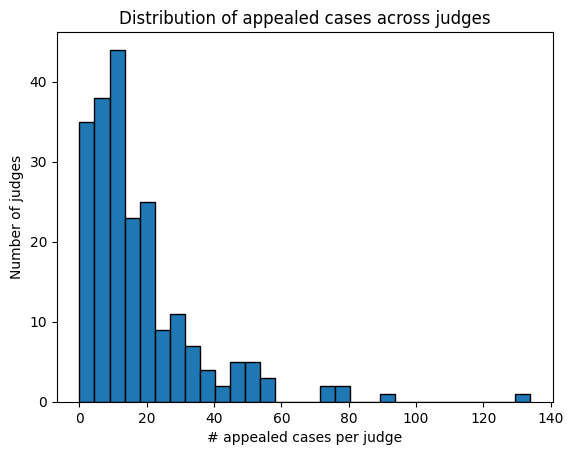

In [159]:
import matplotlib.pyplot as plt

plt.hist(pj["appealed_cases"], bins=30, edgecolor="black")
plt.xlabel("# appealed cases per judge")
plt.ylabel("Number of judges")
plt.title("Distribution of appealed cases across judges")
plt.show()

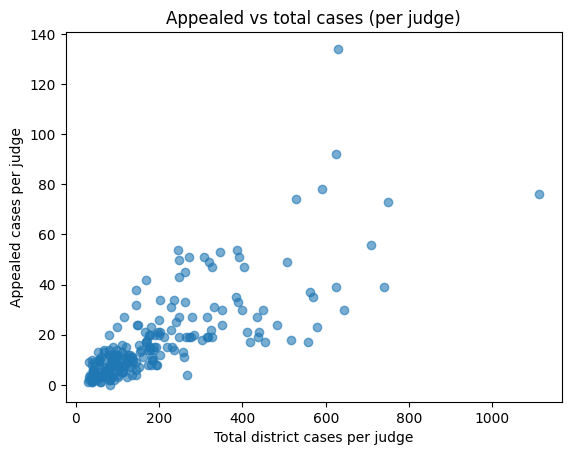

In [160]:
plt.scatter(pj["district cases"], pj["appealed_cases"], alpha=0.6)
plt.xlabel("Total district cases per judge")
plt.ylabel("Appealed cases per judge")
plt.title("Appealed vs total cases (per judge)")
plt.show()